In [1]:
from snn_utils import spiketrains, __gen_ST
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset

In [2]:
class XorDataset(Dataset):

    def __init__(self,data,labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,index):
        X = self.data[index]
        y = self.labels[index]
        return X,y

In [3]:
def generate_xor_data(in_dim=10,time=100,samples_per_type=200):
    on_rate = time
    off_rate = 1
    on_rates = [on_rate] * int((in_dim/2))
    off_rates = [off_rate] * int((in_dim/2))
    oo = np.array([spiketrains(in_dim,time,off_rates + off_rates) for i in range(samples_per_type)])
    oi = np.array([spiketrains(in_dim,time,off_rates + on_rates) for i in range(samples_per_type)])
    io = np.array([spiketrains(in_dim,time,on_rates + off_rates) for i in range(samples_per_type)])
    ii = np.array([spiketrains(in_dim,time,on_rates + on_rates) for i in range(samples_per_type)])
    labels = np.array([0] * samples_per_type + [1] * samples_per_type * 2 + [0] * samples_per_type).reshape(samples_per_type * 4,)
    data = np.concatenate((oo,oi,io,ii))
    return data,labels

#data,labels = generate_xor_data(samples_per_type=100)


In [4]:
def dataloaders_from_data(data,labels,batch_size=40):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(data,labels, test_size=.2,)
    data_train = XorDataset(X_train,y_train)
    data_test = XorDataset(X_test, y_test)

    dataloader_train = DataLoader(data_train, batch_size=batch_size,shuffle=True)
    dataloader_test = DataLoader(data_test, batch_size=batch_size,shuffle=True)
    return dataloader_train, dataloader_test


In [5]:
def xor_dataloaders(in_dim=10,time=100,samples_per_type=200,batch_size=40):
    data, labels = generate_xor_data(in_dim=in_dim,time=time,samples_per_type=samples_per_type)
    dataloader_train, dataloader_test = dataloaders_from_data(data=data,labels=labels,batch_size=batch_size)
    return dataloader_train,dataloader_test

In [6]:
from LIFlayer import NHiddenModel

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'device: {device}')
else:
    device = torch.device("cpu")
    print(f'device: {device}')

device: cuda


In [29]:
import tqdm.notebook as tqdm




decay = .99




def train(dataloader_train,dataloader_test,model,decay,lr=1e-3,epochs=20,device=device):

    ce_loss = torch.nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(),lr=lr)
    train_hist = []
    test_hist = []
    loss_hist = []
    pbar_epochs = tqdm.trange(epochs,leave=False,unit='epoch',position=0)
    for e in pbar_epochs:
        losses = []
        acc_test = []
        acc_train = []


        #test loop
        for x,label in dataloader_test:
            Sprobe = torch.zeros((dataloader_test.batch_size,model.out_channels),device=device)
            x = x.float().to(device)
            label=label.reshape(dataloader_test.batch_size).to(device)
            model.init_states()
            with torch.no_grad():
                for t in range(x.shape[1]):
            

                    out_state = model(x[:,t])

                    Sprobe = decay * Sprobe + out_state.S
                prediction = Sprobe
                acc_test.append(np.mean((np.argmax(prediction.cpu(), axis=1)==label.cpu()).cpu().numpy()))

        #train loop
        for x,label in dataloader_train:
            Sprobe = torch.zeros((dataloader_train.batch_size,model.out_channels),device=device)
            x = x.float().to(device)
            label=label.reshape(dataloader_train.batch_size).to(device)
            model.init_states()
            for t in range(x.shape[1]):
            

                out_state = model(x[:,t])

                Sprobe = decay * Sprobe + out_state.S
                
            prediction = Sprobe
            with torch.no_grad():
                acc_train.append(np.mean((np.argmax(prediction.cpu(), axis=1)==label.cpu()).numpy()))
            loss = ce_loss(prediction,label)
            losses.append(loss.detach().cpu().numpy())

            loss.backward()
            opt.step()
            opt.zero_grad()

        pbar_epochs.set_description(" Loss {0:1.4} | Test Acc {1:2.2%}: | Train Acc {2:2.2%} " .format(np.mean(losses),np.mean(acc_test),np.mean(acc_train)))
        loss_hist.append(np.mean(losses))
        train_hist.append(np.mean(acc_train))
        test_hist.append(np.mean(acc_test))
    return loss_hist,train_hist,test_hist

tensor(3., requires_grad=True)

In [30]:
loss_dict = {}
train_dict = {}
test_dict = {}
pbar_layers = tqdm.trange(10,unit='exp')

for layers in pbar_layers:
    pbar_reps = tqdm.trange(3,leave=False,unit='run')
    #for rep in tqdm.tqdm(range(3),leave=False,desc=f'Repetition: {rep}'):
    for rep in pbar_reps:
        model = NHiddenModel(layers,10,10,2,with_recurrent=False).to(device)

        dataloader_train,dataloader_test = xor_dataloaders(in_dim=10,time=100,samples_per_type=100,batch_size=20)
        lossh, trainh, testh = train(dataloader_train=dataloader_train,dataloader_test=dataloader_test,model=model,decay=.99,epochs=20)

        loss_dict[f'{layers}_layers_rep_{rep}'] = lossh
        train_dict[f'{layers}_layers_rep_{rep}'] = trainh
        test_dict[f'{layers}_layers_rep_{rep}'] = testh
        
    pbar_layers.set_description(f'')

  0%|          | 0/10 [00:00<?, ?exp/s]

  0%|          | 0/3 [00:00<?, ?run/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/3 [00:00<?, ?run/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/3 [00:00<?, ?run/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/3 [00:00<?, ?run/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/3 [00:00<?, ?run/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/3 [00:00<?, ?run/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/3 [00:00<?, ?run/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/3 [00:00<?, ?run/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/3 [00:00<?, ?run/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/3 [00:00<?, ?run/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/20 [00:00<?, ?epoch/s]

In [32]:
import pickle

with open('lossdict.p', 'wb') as fp:
    pickle.dump(loss_dict, fp)
with open('traindict.p', 'wb') as fp:
    pickle.dump(train_dict, fp)
with open('testdict.p', 'wb') as fp:
    pickle.dump(test_dict, fp)

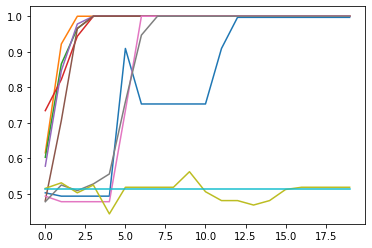

In [230]:
for i in range(10):
    plt.plot(train_dict[f'{i}-layers'])


In [ ]:
pbar = tqdm.trange(Nepochs)
for epoch in pbar: 
    loss = 0
    acc = []
    # Test loop
    for Sin, target in dataloader_test: 
        Sin = Sin.to(device).transpose(0,1)
        target = target.to(device)
        with torch.no_grad(): # Do not change weights during testing
            state = net(Sin)
            tgt = target.cpu().numpy()
            pred = state.S.clone().cpu().numpy()
            acc.append(np.mean(np.argmax(pred, axis=1)==tgt))
    # Training loop
    for Sin, target in dataloader_train:
        Sin = Sin.to(device).transpose(0,1)
        target = target.to(device).long() # PyTorch loss function requires Long-type
        state = net(Sin)
        print("S:", state.U)
        loss_seq = loss_fn(state.S, target)
        loss_seq.backward()
        opt.step()
        opt.zero_grad()
        loss += loss_seq

    pbar.set_description("Training Loss {0} | Accuracy {1:2.2%}: | " .format(loss_t,np.mean(acc)))

In [97]:
prediction

tensor([[12.3289, 15.0956],
        [ 1.3672,  1.4566],
        [ 8.2649, 10.3427],
        [12.3289, 15.0956],
        [ 9.6349,  6.9352],
        [12.3289, 15.0956],
        [ 9.6278,  6.9012],
        [ 1.9193,  1.5510],
        [ 2.5024,  2.1416],
        [ 9.6150,  7.0019],
        [ 8.2649, 10.3427],
        [ 9.6340,  6.9837],
        [ 8.2649, 10.3427],
        [12.3289, 15.0956],
        [ 9.6150,  7.0019],
        [ 1.1473,  1.1866],
        [ 9.6973,  6.9069],
        [12.3289, 15.0956],
        [12.3289, 15.0956],
        [12.3289, 15.0956],
        [ 8.2649, 10.3427],
        [ 0.3772,  0.0000],
        [ 9.1906, 10.4346],
        [ 9.6852,  6.9258],
        [12.3289, 15.0956],
        [ 8.2649, 10.3427],
        [ 9.6340,  6.9837],
        [ 9.6097,  6.9223],
        [ 8.2649, 10.3427],
        [ 9.6150,  7.0019],
        [12.3289, 15.0956],
        [ 8.2649, 10.3427],
        [12.3289, 15.0956],
        [ 1.1709,  1.7936],
        [12.3289, 15.0956],
        [ 9.6340,  6

In [99]:
label

tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1])

In [105]:
np.mean([True,True,False])

0.6666666666666666

In [108]:
np.mean((np.argmax(prediction, axis=1)==label).numpy())

0.325

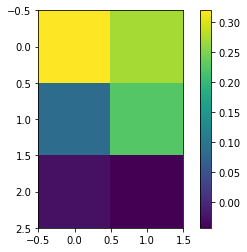

In [48]:
plt.imshow(model.layers[0].fc_layer.weight.data)
plt.colorbar()

In [35]:
model.layers[0].fc_layer.weight.data

tensor([[ 0.0096, -0.0393],
        [ 0.0715, -0.1028],
        [ 0.2063, -0.1354]])

In [208]:
oo.shape

AttributeError: 'list' object has no attribute 'shape'

In [205]:
temp.

array([100.,   1.])

In [199]:
data = np.zeros((500,100,2))
data[0:250,:,0] = S_active[0:250,:,0]
data[125:375,:,1] = S_active[125:375,:,0]
data[0:125,:,1] = S_inactive[0:125,:,0]
data[250:,:,0] = S_inactive[250:,:,0]
data[375:,:,1] = S_inactive[125:250:,:,0]

In [76]:
S_active.shape
S_inactive.shape

(200, 100, 1)

In [77]:
data = np.zeros((500,100,2))

In [85]:
S_active[np.random.randint(0,200),:,0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [113]:
np.random.randint(0,200)

51

In [172]:
data[0:250,:,0] = S_active[0:250,:,0]
data[125:375,:,1] = S_active[125:375,:,0]
data[0:125,:,1] = S_inactive[0:125,:,0]
data[250:,:,0] = S_inactive[250:,:,0]
data[375:,:,1] = S_inactive[125:250:,:,0]

In [185]:
data[0].sum()

100.0

In [188]:
labels = [0 if entry.sum()>150 or entry.sum() < 50 else 1 for entry in data]

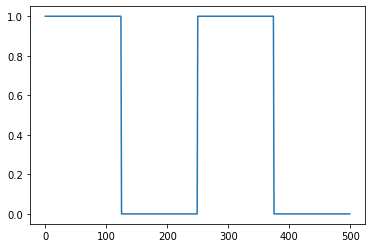

In [190]:
plt.plot(labels)

In [67]:
X[0][:,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [68]:
S_active[0]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [52]:
X[0,:,0] = S_active[0]

ValueError: could not broadcast input array from shape (100,1) into shape (100,)

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.

In [58]:
spikes

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]],

       [[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.